r2 seemed to lose contact with attenuation during this data set, so all have the same attenuation

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from kid_readout.measurement.io import npy
from kid_readout.measurement import basic, plot_basic

In [2]:
npd = npy.NumpyDirectory('/data/readout/2017-12-14_173007_mmw_test.npd/')

In [3]:
npd.node_names()

['SingleSweep0',
 'SingleSweepStreamList1',
 'ADCSnap2',
 'SingleSweepStreamList3',
 'ADCSnap4',
 'SingleSweepStreamList5',
 'ADCSnap6']

In [4]:
initial = npd.SingleSweep0
all_sssl = [npd.read(name) for name in npd.node_names() if name.startswith('SingleSweepStreamList')]
all_snap = [npd.read(name) for name in npd.node_names() if name.startswith('ADCSnap')]

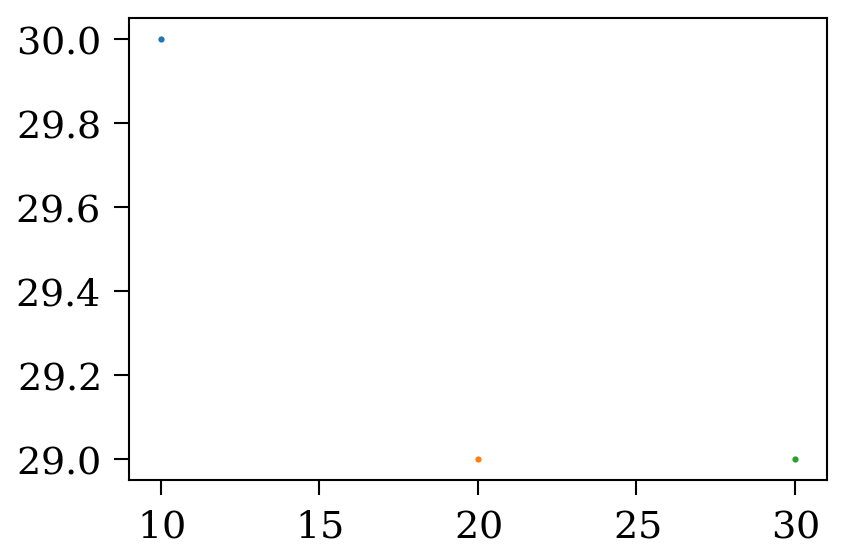

In [37]:
fig, ax = plt.subplots()
for sssl, snap in zip(all_sssl, all_snap):
    ax.plot(sssl.stream_list[2].roach_state.dac_attenuation, snap.x.ptp(), '.')

In [5]:
def sss_from_sssl(sssl):
    stream_off, stream_mod, stream_on = sssl.stream_list
    sss_off = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=stream_off)
    sss_mod = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=stream_mod)
    sss_on = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=stream_on)
    return sss_off, sss_mod, sss_on

In [6]:
all_sss = [sss_from_sssl(sssl) for sssl in all_sssl]

In [38]:
def plot_sssl(sss_off, sss_mod, sss_on):
    fig, (ax_off, ax_mod, ax_on) = plt.subplots(1, 3, figsize=(5, 2),
                                                gridspec_kw={'hspace': 0.4, 'wspace': 0.5})
    plot_basic.sss_complex_plane(axis=ax_off, sss=sss_off)
    ax_off.set_title("off, {:.1f} dB".format(sss_off.stream.roach_state.dac_attenuation), fontsize='xx-small')
    plot_basic.sss_complex_plane(axis=ax_mod, sss=sss_mod)
    ax_mod.set_title("mod, {:.1f} dB".format(sss_mod.stream.roach_state.dac_attenuation), fontsize='xx-small') 
    plot_basic.sss_complex_plane(axis=ax_on, sss=sss_on)
    ax_on.set_title("on, {:.1f} dB".format(sss_off.stream.roach_state.dac_attenuation), fontsize='xx-small')
    for ax in (ax_off, ax_mod, ax_on):
            ax.tick_params(labelsize='xx-small')
    return fig, (ax_off, ax_mod, ax_on)


def plot_folded(ssl):
    num_resonators = ssl.sweep.num_channels - ssl.state.num_dummy_frequencies
    fig, axes = plt.subplots(num_resonators, 1, figsize=(2, 1 * num_resonators),
                             gridspec_kw={'hspace': 0.4, 'wspace': 0.5})
    for number, ax in enumerate(axes):
        sss_mod = basic.SingleSweepStream(sweep=ssl.sweep[number], stream=ssl.stream_list[1][number])
        x_fold = sss_mod.fold(sss_mod.x)
        q_fold = sss_mod.fold(sss_mod.q)
        time = sss_mod.stream.sample_time[:x_fold.size]
        ax.plot(1e3 * time, 1e6 * (x_fold - x_fold.mean()))
        ax.plot(1e3 * time, 1e6 * (q_fold - q_fold.mean()))
    axes[-1].set_xlabel('time / ms', fontsize='xx-small')
    axes[-1].set_ylabel('response', fontsize='xx-small')
    return fig, axes


def plot_Sxx(ax, sss_off, sss_mod, sss_on):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('frequency / Hz')
    ax.set_ylabel('spectral density / Hz$^{-1}$')
    ax.plot(sss_off.S_frequency, sss_off.S_xx, label='off: $S_{xx}$')
    ax.plot(sss_mod.S_frequency, sss_mod.S_xx, label='mod: $S_{xx}$')
    ax.plot(sss_on.S_frequency, sss_on.S_xx, label='on: $S_{xx}$')
    ax.legend(fontsize='xx-small')

def plot_Sxx_attenuation(ax, *some_sss):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('frequency / Hz')
    ax.set_ylabel('spectral density / Hz$^{-1}$')    
    for sss in some_sss:
        ax.plot(sss.S_frequency, sss.S_xx, label='{:.1f} dB'.format(sss.stream.roach_state.dac_attenuation))
    ax.legend(fontsize='xx-small')

def plot_Sxx_Syy_attenuation(ax, *some_sss):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('frequency / Hz')
    ax.set_ylabel('spectral density / Hz$^{-1}$')    
    for sss in some_sss:
        ax.plot(sss.S_frequency, sss.S_xx,
                linestyle='-', label='$S_{xx}$: ' + '{:.1f} dB'.format(sss.stream.roach_state.dac_attenuation))
        ax.plot(sss.S_frequency, sss.S_yy,
                linestyle='--', label='$S_{yy}$: ' + '{:.1f} dB'.format(sss.stream.roach_state.dac_attenuation))
    ax.legend(fontsize='xx-small')

def plot_folded_masked(ssl):
    num_resonators = ssl.sweep.num_channels - ssl.state.num_dummy_frequencies
    fig, axes = plt.subplots(num_resonators, 1, figsize=(2, 1 * num_resonators),
                             gridspec_kw={'hspace': 0.4, 'wspace': 0.5})
    for number, ax in enumerate(axes):
        sss_mod = basic.SingleSweepStream(sweep=ssl.sweep[number], stream=ssl.stream_list[1][number])
        x_fold = sss_mod.fold(sss_mod.x)
        #q_fold = sss_mod.fold(sss_mod.q)
        time = sss_mod.stream.sample_time[:x_fold.size]
        left_mask, right_mask = periodic.mask_left_right(x_fold.size, skip=0.1)
        p2p, p2p_error = periodic.peak_to_peak(x_fold)
        ax.plot(1e3 * time, 1e6 * (x_fold - x_fold.mean()), color='gray',
                label="{:.2f} $\pm$ {:.2f}".format(1e6 * p2p, 1e6 * p2p_error))
        ax.plot(1e3 * time[left_mask], 1e6 * (x_fold - x_fold.mean())[left_mask], color='red')
        ax.plot(1e3 * time[right_mask], 1e6 * (x_fold - x_fold.mean())[right_mask], color='green')
        ax.legend(fontsize='xx-small')
    axes[-1].set_xlabel('time / ms', fontsize='xx-small')
    axes[-1].set_ylabel('response', fontsize='xx-small')
    return fig, axes    

def decimate(sss, num_taps=256, downsample=8):
    f_nyquist = sss.stream.stream_sample_rate / 2
    x_lpf = filters.low_pass_fir(sss.x, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    q_lpf = filters.low_pass_fir(sss.q, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    t = sss.stream.sample_time[::downsample]
    size = min(t.size, x_lpf.size)
    return t[:size], x_lpf[:size], q_lpf[:size]

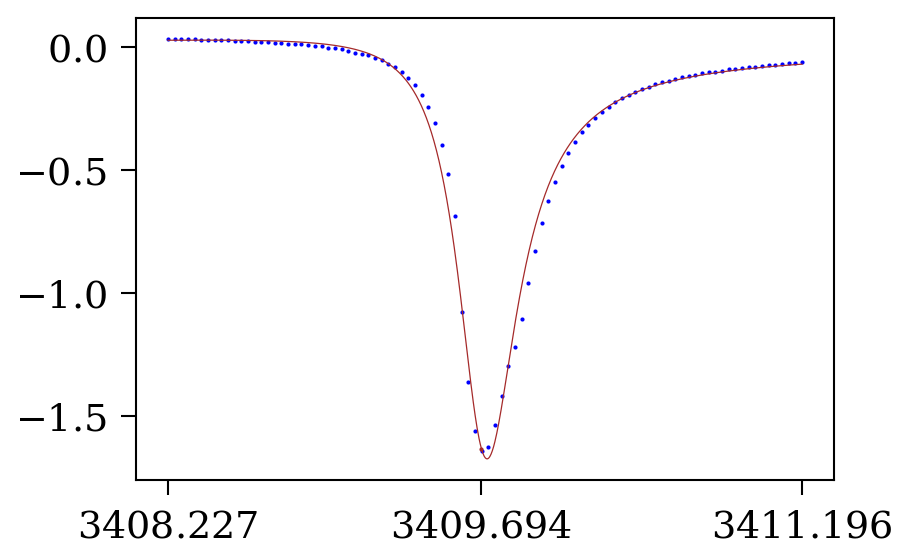

In [8]:
fig, ax = plt.subplots()
plot_basic.resonator_amplitude(axis=ax, resonator=initial.resonator);

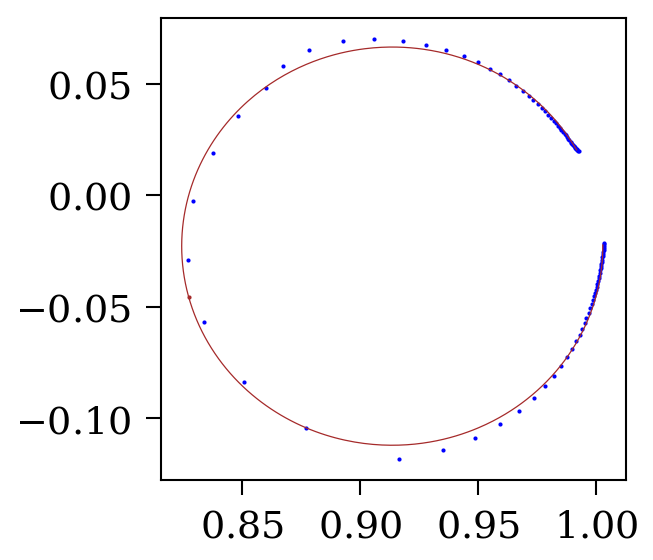

In [9]:
fig, ax = plt.subplots(figsize=(2, 2))
plot_basic.resonator_complex_plane(axis=ax, resonator=initial.resonator);

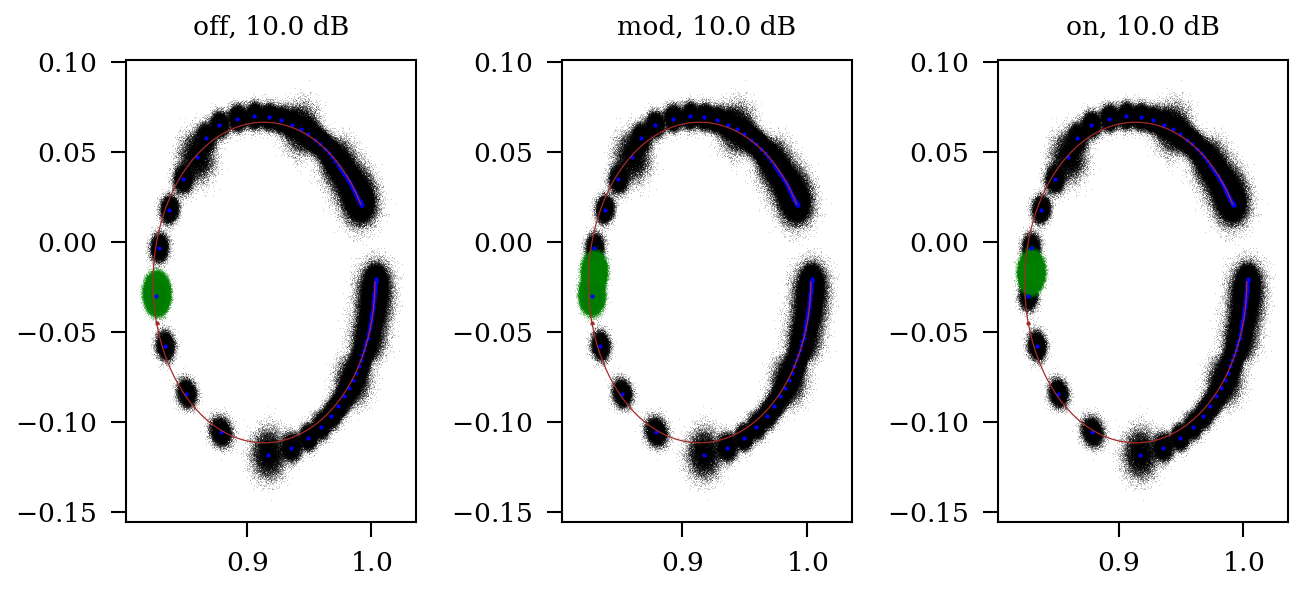

In [10]:
fig, axes = plot_sssl(*all_sss[0])

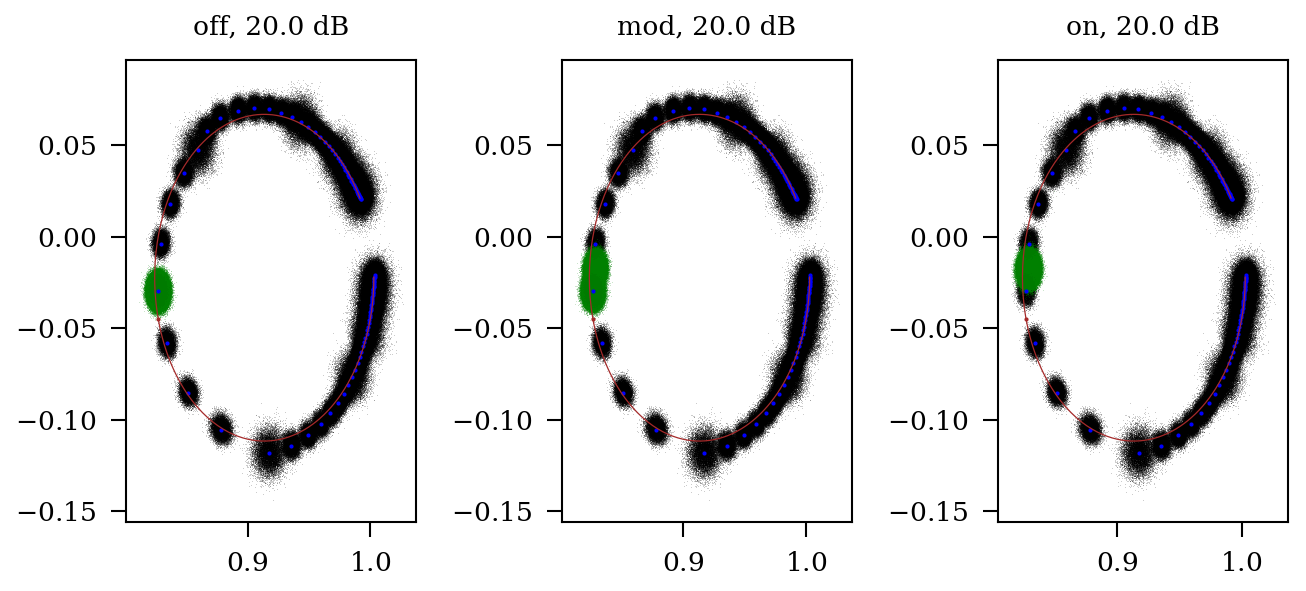

In [11]:
fig, axes = plot_sssl(*all_sss[1])

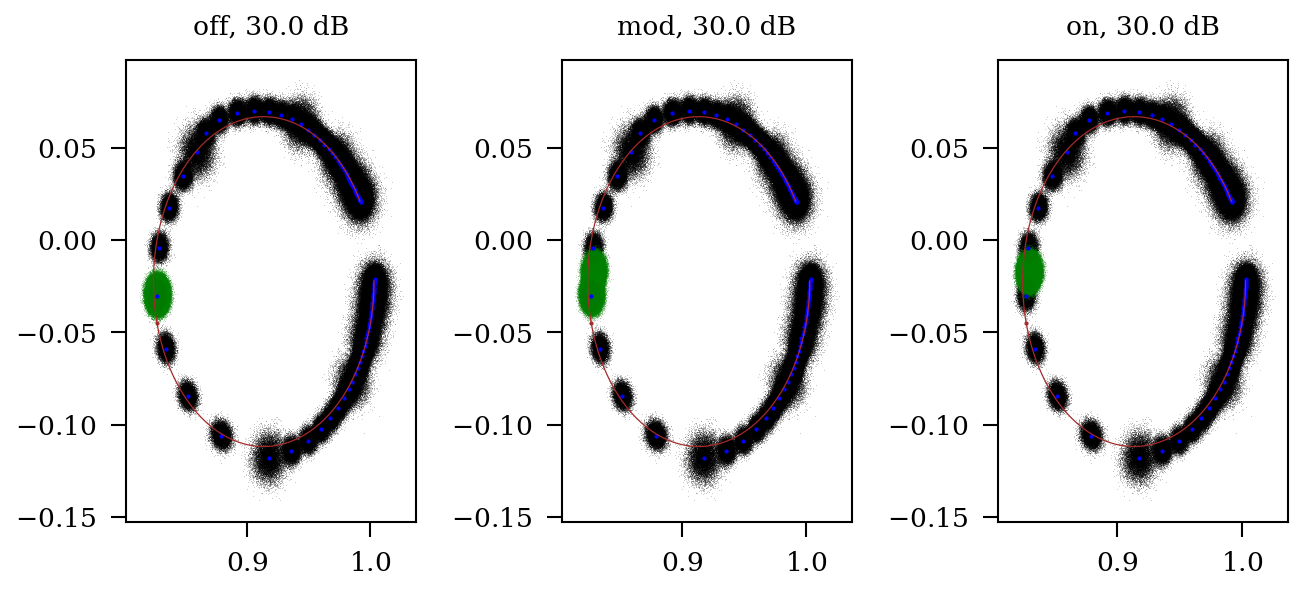

In [12]:
fig, axes = plot_sssl(*all_sss[2])

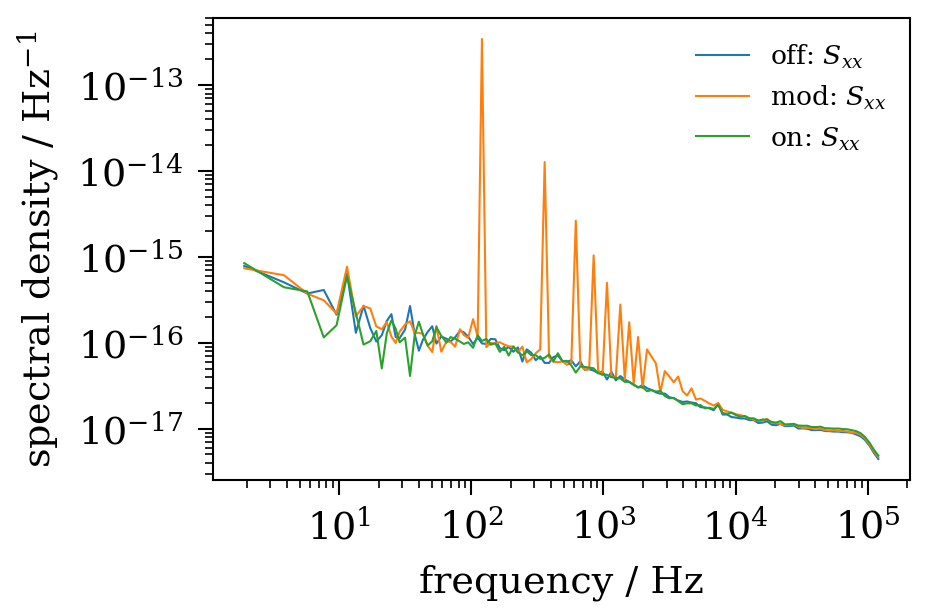

In [39]:
fig, ax = plt.subplots()
plot_Sxx(ax, *all_sss[0])

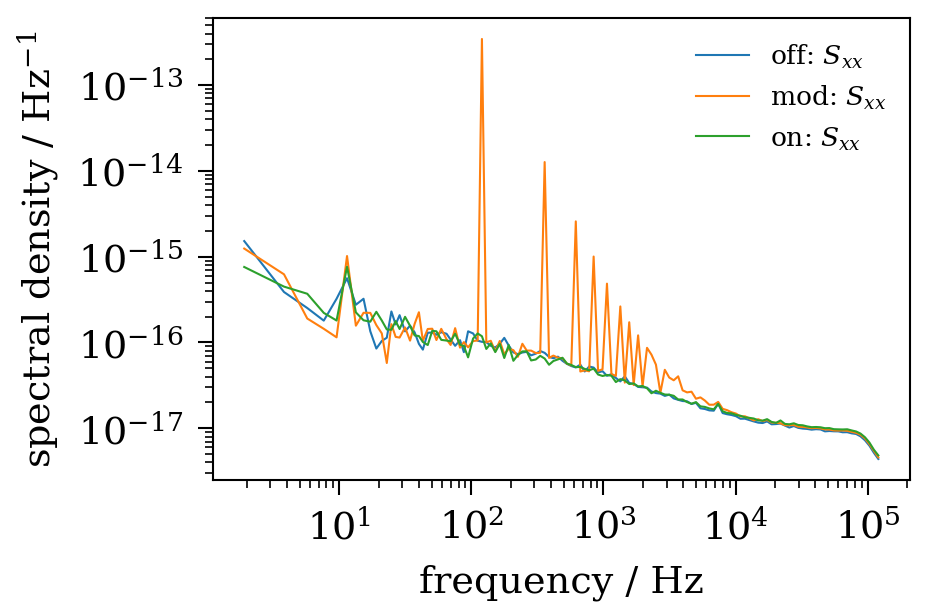

In [40]:
fig, ax = plt.subplots()
plot_Sxx(ax, *all_sss[1])

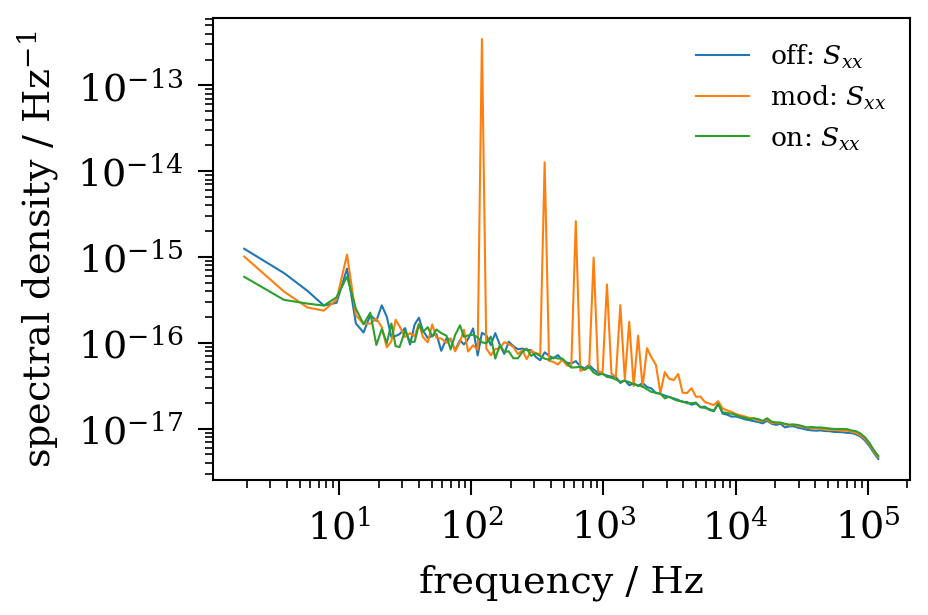

In [41]:
fig, ax = plt.subplots()
plot_Sxx(ax, *all_sss[2])

In [32]:
sss_off = [sss_tuple[0] for sss_tuple in all_sss]
sss_mod = [sss_tuple[1] for sss_tuple in all_sss]
sss_on = [sss_tuple[2] for sss_tuple in all_sss]

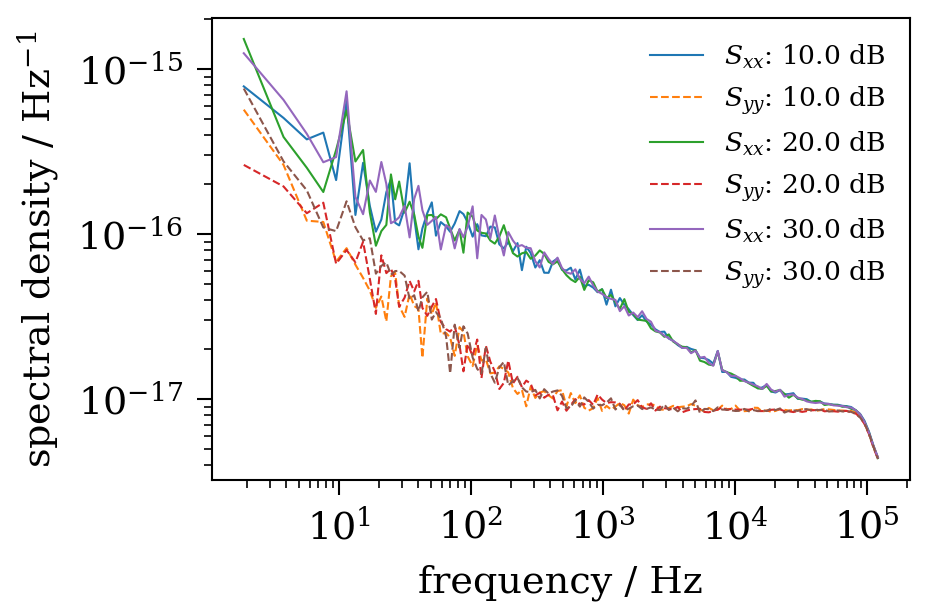

In [33]:
fig, ax = plt.subplots()
plot_Sxx_Syy_attenuation(ax, *sss_off)

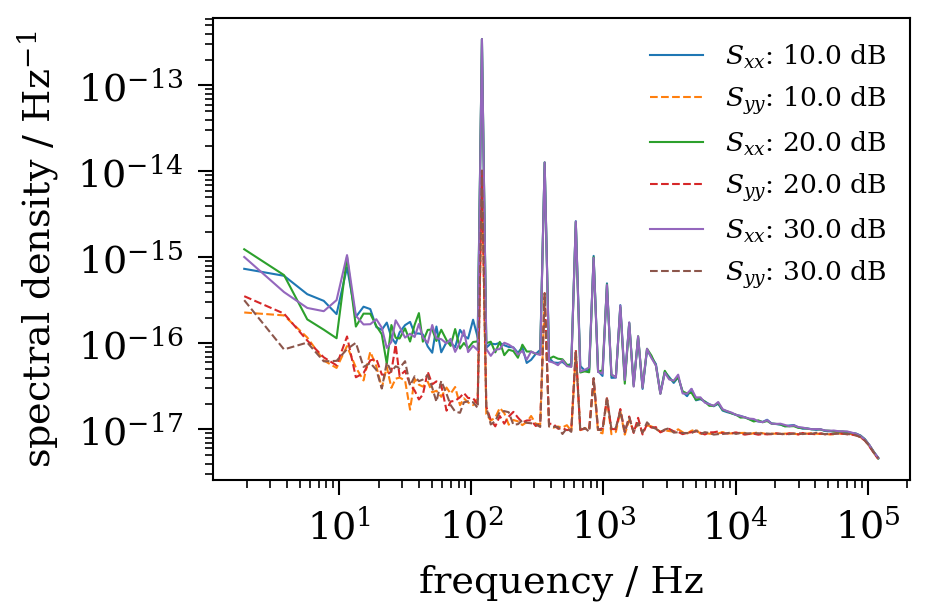

In [34]:
fig, ax = plt.subplots()
plot_Sxx_Syy_attenuation(ax, *sss_mod)

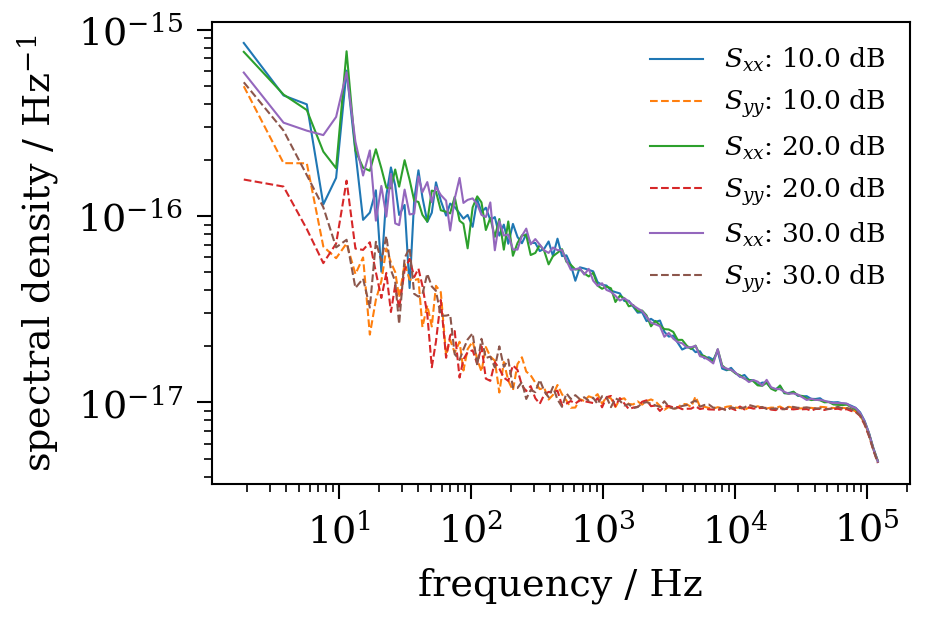

In [35]:
fig, ax = plt.subplots()
plot_Sxx_Syy_attenuation(ax, *sss_on)